## Starting to make a more generic G-Code library for 2429 tools 2022 2010 CJH
* made a library called simplegcode
* user just generates the points and tells the code which machine they want
  * shapeoko brute force plunges all drilling
  * benchmill uses a G82 (spot drill) or G83 (peck drill) cycle
* has functions 
  * generate_gcode() to get the gcode and
  * plot_points() to get a plot of the points


In [1]:
import simplegcode as sg
import pandas as pd
from importlib import reload

#### simple way to generate a grid - you can override and put in arbitrary points

In [33]:
# simple way to generate a grid
x_start, x_spacing = 0.5, 0.5
y_start, y_spacing = -0.5, -1
x_repeats = 3  # minimum 1
y_repeats = 2  # minimum 1
x = [x_start + x_spacing * _ for _ in range(x_repeats)]
y = [y_start + y_spacing * _ for _ in range(y_repeats)]
point_list = [(x_, y_) for x_ in x for y_ in y]

# center gussset
initial_list = [[1,0.25],[1,3.75],[1,1.063],[0.188,1.531],
 [1.812,1.531], [ 0.188, 2.469], [1.812, 2.469],
 [1, 2.938,], [0,0], [2, 0], [0,4], [2,4]
]

# piston mount
initial_list = [[0.25, 0.50],[0.25,1.50],[1.25,0.5],[1.25,1.5],
 [0.85,3.125], [0,0], [1.5, 0], [0,3.6], [1.5,3.6]
]

# andymark gusset 90-deg
point_list = [[0.5, 0.5], [1.5,0.5], [2.5,0.5], [0.5, 1.5], [0.5, 2.5], [0,0], [3,3], [0,3], [3,0]]

# ratchet pawl v1
initial_list = [
    [0.15, 2.70], [0.680, 2.170], [0, 0], [1, 0], [0, 3], [1, 3]
]

# andymark gusset 90-deg
initial_list = [[0.5, 0.5], [1.5,0.5], [2.5,0.5], [0.5, 1.5], [0.5, 2.5], [0,0], [3,3], [0,3], [3,0]]

# ratchet pawl v2 - actually the same w.r.t the sketch
initial_list = [
    [0.15, 2.70], [0.680, 2.170], [0, 0], [1, 0], [0, 3], [1, 3]
]

x_spacing = 1 # the period of the item being machined - bounding box x range
x_padding = 1 # 1 inch padding
duplicates = 2 # how many do I want
point_list = []
[point_list.append([p[0]+(x_spacing+ x_padding)*offset, p[1]]) for p in initial_list for offset in range(duplicates)]

# print out and see if we have what we need
x = [point[0] for point in point_list]
y = [point[1] for point in point_list]
print(f'x range: ({min(x)},{max(x)})  y range: ({min(y)},{max(y)})\npointlist: {point_list}')

x range: (0,3)  y range: (0,3)
pointlist: [[0.15, 2.7], [2.15, 2.7], [0.68, 2.17], [2.68, 2.17], [0, 0], [2, 0], [1, 0], [3, 0], [0, 3], [2, 3], [1, 3], [3, 3]]


In [27]:
file = 'stage1sideplate.csv'
df = pd.read_csv(file)
point_list = [ (df['XLOC'][i], df['YLOC'][i]) for i in range(len(df))]
[point_list.append(x) for x in [[0, 0], [0, 21.6], [15.7, 0], [15.7, 21.6]] ]
point_list

[(0.375, 11.0),
 (0.375, 12.0),
 (0.5, 0.543),
 (0.5, 1.793),
 (0.5, 3.043),
 (1.5, 0.543),
 (1.5, 1.793),
 (1.5, 3.043),
 (11.5, 4.418),
 (11.5, 5.418),
 (11.5, 6.418),
 (11.5, 7.418),
 (11.5, 8.418),
 (11.5, 9.418),
 (11.5, 10.418),
 (11.5, 11.418),
 (11.5, 12.418),
 (15.325, 17.0),
 (15.325, 18.0),
 (0.543, 13.684),
 (0.543, 15.098),
 (1.957, 13.684),
 (1.957, 15.098),
 (13.418, 12.293),
 (13.418, 13.707),
 (14.832, 12.293),
 (14.832, 13.707),
 (1.25, 14.391),
 (2.0, 17.5),
 (14.125, 13.0),
 (2.25, 13.0),
 (3.75, 7.466),
 (9.7, 2.444),
 (12.419, 20.0),
 (12.5, 16.1),
 [0, 0],
 [0, 21.6],
 [15.7, 0],
 [15.7, 21.6]]

#### default options you can override by passing a dict to generate_gcode()

In [28]:
# options you can override
_ = [print(f'{d}: {sg.settings_dict[d]}') for d in sg.settings_dict]

shapeoko: {'DRILL_DEPTH': -0.1, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05, 'LINEAR_FEED': 100, 'DRILL_FEED': 2, 'RETRACT_FEED': 30}
benchmill: {'DRILL_DEPTH': -0.2, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.1, 'LINEAR_FEED': 30, 'DRILL_FEED': 3, 'RETRACT_FEED': 20, 'TOOL': 4, 'PECK_TOOL': 5, 'PECK_STEP': 0.05}


#### example call 

In [36]:
machine = 'shapeoko'  # shapeoko or benchmill
overrides = {'DRILL_FEED':2,'DRILL_DEPTH':-0.1, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05} # dictionary of what to change from default
reload(sg)
code = sg.generate_gcode(point_list, machine=machine, peck=True, overrides=overrides, 
                         save_file=True, file_description='pawlv2_2x')
#print(code)

Using the following settings: {'DRILL_DEPTH': -0.1, 'RETRACT_HEIGHT': 0.5, 'ENGAGE_HEIGHT': 0.05, 'LINEAR_FEED': 100, 'DRILL_FEED': 2, 'RETRACT_FEED': 30}



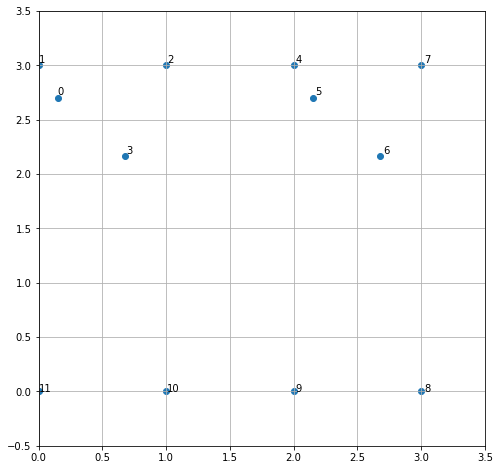

In [37]:
sg.plot_points(point_list, annotate=False, show_order=True)